In [1]:
import sys
sys.path.append('../')

import os
import librosa
import numpy as np
import pandas as pd
from glob import glob
import tensorflow as tf
import matplotlib.pyplot as plt

from IPython import display

from utils.voice.wav_utils import *
# from utils.voice.prepare_dataset import *
from models import M02
from utils.voice.data_split import split_data
from utils.sys_logger import SysLogger
from utils.voice.whistle_dataloader import WhistleDataloaderSpectrogram
from utils.voice.whistle_detection import WhistleDetection

import pdb

%load_ext autoreload
%autoreload 2

# Reading Wav files with Librosa
Visualizing waveform of training example and listening to audio

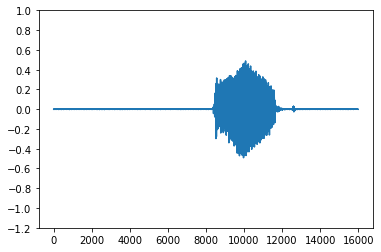

In [5]:
file_path = r"D:\Advait\Handouts_and_assignments\Raspberry_Pi\whistle_activated_camera\data\voice_data\bed\78622c2b_nohash_0.wav"
y, sr = librosa.load(file_path, sr=16000)
plt.plot(y)
plt.yticks(np.arange(-1.2, 1.2, 0.2))
plt.show()

In [6]:
display.Audio(file_path)

# Preparing Audio Dataset
Using custom data augmentation maximize the diversity of sounds in the dataset and train a robust model

* Mix FG (human voice samples) with BG (backgorund noise samples)

* In ~50% of training samples, mix WH (whistle) audio clips

```
wav_mix = alpha * fg + (1-alpha) * bg
wh_mix = beta * wh + (1-beta) * wav_mix
```
where ```alpha``` and ```beta``` are sampled form uniform distribution ```U(0,1)``` 

Some notes on mixing audio files:

* FG and BG audio samples should be sampled at the same rate to prevent introducing artifacts

* In this dataset FG samples are typically shorter than BG samples (4s). Padding FG with a random shift increases data diversity and helps the model to learn features which are independent of temporal location of audio features

* Subtract mean amplitude before mixing audio samples

* Lower bound beta by some constant ```beta_0``` to ensure model learns to recognize "correct" features

* In an attempt to expose the model to a large variety of samples (and ultimately hoping to reduce model variance) audio mixing of training data is done for a subset of training data at the beginning of each epoch. This allows model to train without having to load the entire dataset in memory and increases the variety of samples that can be generated and fed to the model.

(64000,) (64000,)


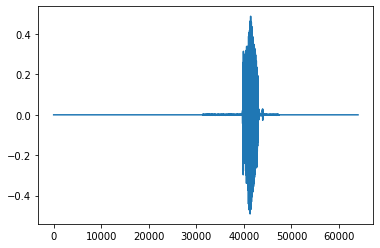

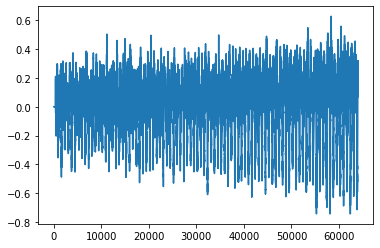

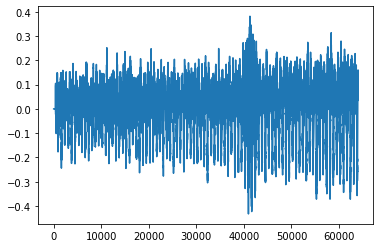

In [7]:
# naive mixing of audio data -- not used in dataset generation


file_path1 = r"D:\Advait\Handouts_and_assignments\Raspberry_Pi\whistle_activated_camera\data\voice_data\bed\78622c2b_nohash_0.wav"
y1, sr1 = librosa.load(file_path1, sr=16000)

file_path2 = r"D:\Advait\Handouts_and_assignments\Raspberry_Pi\whistle_activated_camera\data\UrbanSound8K\UrbanSound8K\audio\fold3\6988-5-0-0.wav"
y2, sr2 = librosa.load(file_path2, sr=16000)

y1_pad = pad_random(y1, y2.shape[0])

print(y1_pad.shape, y2.shape)

y = (y1_pad+y2) / 2

plt.figure(1)
plt.plot(y1_pad)

plt.figure(2)
plt.plot(y2)

plt.figure(3)
plt.plot(y)

plt.show()

display.Audio(y, rate=sr1)

..\data\voice_data\no\6c429c7b_nohash_0.wav ..\data\UrbanSound8K\UrbanSound8K\audio\fold10\136558-9-1-21.wav
(88200,) (88200,)


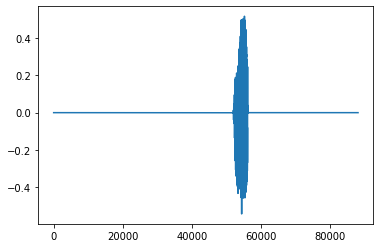

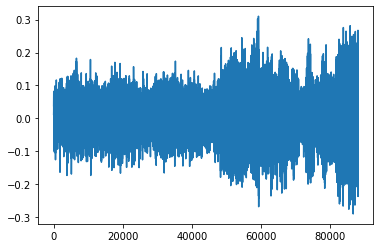

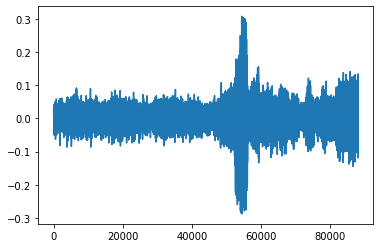

In [8]:
# mixing FG + BG audio samples

def show_plots(y1, sr1, y2, sr2):
    y1_pad = pad_random(y1, y2.shape[0])

    print(y1_pad.shape, y2.shape)

    y = (y1_pad+y2) / 2

    plt.figure(1)
    plt.plot(y1_pad)

    plt.figure(2)
    plt.plot(y2)

    plt.figure(3)
    plt.plot(y)

    plt.show()

def list_file_names(file_path, pattern="*.wav"):
    files = []
    for root, _, _ in os.walk(file_path):
        matched_files = glob(os.path.join(root, pattern))
        files += matched_files
    return files

num_mixed_sounds_to_generate = 1

fg_sounds_list = list_file_names(r'..\data\voice_data')
bg_sounds_list = list_file_names(r'..\data\UrbanSound8K')
alpha = np.random.uniform(low=0, high=1, size=[num_mixed_sounds_to_generate])

for i in range(num_mixed_sounds_to_generate):
    fg_sound_name = fg_sounds_list[np.random.randint(len(fg_sounds_list))]
    bg_sound_name = bg_sounds_list[np.random.randint(len(bg_sounds_list))]
    print(fg_sound_name, bg_sound_name)
    
    fg_sound, fg_sample_rate = librosa.load(fg_sound_name)
    bg_sound, bg_sample_rate = librosa.load(bg_sound_name)
    
    fg_sound_pad = librosa.util.pad_center(fg_sound, bg_sound.shape[0], axis=0)
    mixed_sound = alpha[i] * fg_sound_pad + (1 - alpha[i]) * bg_sound
    show_plots(fg_sound, fg_sample_rate, bg_sound, bg_sample_rate)

## Splitting Training and Validation data
The training and validation data is taken from 3 datasets:

[1] BG Data from the UrbanSound8k dataset
J. Salamon, C. Jacoby and J. P. Bello, "A Dataset and Taxonomy for Urban Sound Research", 22nd ACM International Conference on Multimedia, Orlando USA, Nov. 2014.

[2] FG Data from Speech Commands dataset: https://arxiv.org/abs/1804.03209

[3] WH data: Whistle sounds collected on my phone :)


Each dataset is split into seperate training and validation sets with a 75-25 split

In [9]:
base_folders = {'whistle_folder': r'..\data\whistle',
                'fg_folder': r'..\data\voice_data',
                'bg_folder': r'..\data\UrbanSound8K'}
split_data(base_folders, seed=0)

# Data Visualization and Feature Extraction
The task of whistle detection is not as involved as some advanced audio signal processing tasks like Keyword spotting, voice-identy authentication etc. Hence a relatively simple model and fairly rough features should do the trick.

Exploring two types of features:

* Spectrogram based features (to feed to a CNN)
* MFCC features (to feed to MLP)

## Spectrogram-based Features
Spectrograms are a very robust and informative feature which allow converting audio data into images.
Won't go into the details of what a spectrogram is, but there are some important considerations while extracting a spectrogram from an audio sample:

* Frequncy resolution of the spectrogram is determined by the FFT size and the sampling rate of audio data. The audio dataset is sampled at 16k, so the Nyquist frequency is around 8kHz. Chossing a large FFT size (256) gives us a highly resolved spectrogram in the frequency space. We can observe narrow band features like whistles! But it can't be too large beacause it adds to latency and increases spectrogram size.

* The core algo behind the spectrogram is the STFT. There are a couple of parameters to choose while taking the STFT apart from the FFT size.

    * Window size: Window size should match the FFT length to ensure we are smoothing our data at the edges before performing FFT to prevent some aliasing-related artifacts.
    
    * Window Function: FFT forces our data to repeat in spatial domain in every "Window size"-d chuncks. By having a windowing function we are allowing our data to "taper" off at the edges. There are several, really neat functions we can use for our windowing functions. I have been sloppy and have decided to go with the vanilla "Hanning" window function. 
    
    * Hop Length: A small hop length allows us to get a highly resolved spectrogram/stft in the temporal space. This can be useful if we want to detect transient sounds. I don't want my model to be that sensitive because it would cause a latency overload. I am choosing a hop size of 512. 
    
* Since I am feeding the spectrogram to a CNN (which will have standard "square" kernels), it helps if the spectrogram is approximately a square. I have adjusted the audio sample duration (4s) and other spectrogram parameters above so the raw spectrgram I compute is of size 129x126 which is close to being a suare image

* I do not expect my model to learn some nuanced features in the spectrogram. I just want the model to detect my whistles. My model is going to have to run in real-time so it makes sense to try to minimize the model complexity. I downsample my spectrogram to size 64x64 using anti-aliasing LPF followed by bilinear interpolation. I think this should work because even after this downsampling, I am visually able make out the difference in images which have whistles vs which don't have whistles.

In [10]:
def plot_spectrogram(spectrogram, ax):
    log_spec = np.log(spectrogram.T)
    height = log_spec.shape[0]
    X = np.arange(log_spec.shape[1])
    Y = range(height)
    ax.pcolormesh(X, Y, log_spec)

## Writing custom dataloaders in Tensorflow 2
Tensorflow >= 2.0 allows us to write custom data loaders with a clean interface. I have extended the ```tf.keras.utils.Sequence``` class to write my own dataloader class ```WhistleDataloaderSpectrogram```

Won't go into the the implementation details in this notebook (refer to https://github.com/AdvaitKoparkar/DLPapers for a more involved explanation). You can also check out my custom audio dataloader in ```..\utils\voice\whistle_dataloader.py```

It performs all the preprocessing and data augmentation described in the notebook.

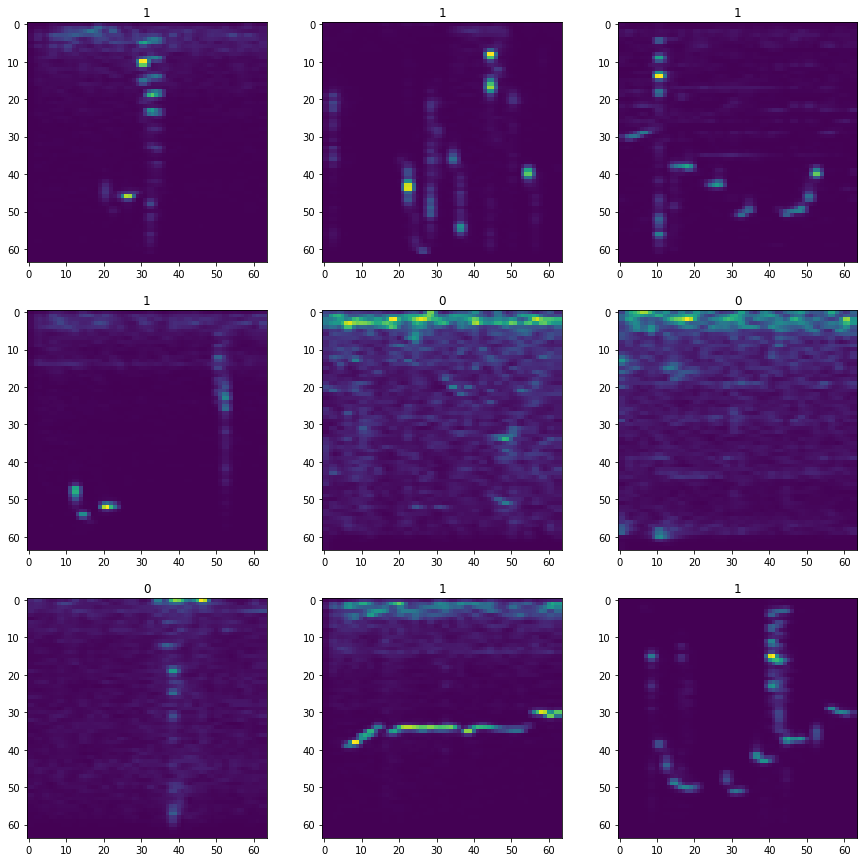

In [11]:
ROWS, COLS = 3, 3

fg_files = pd.read_csv(r'..\data\csv\train\fg.csv')['fname'].unique()
bg_files = pd.read_csv(r'..\data\csv\train\bg.csv')['fname'].unique()
wh_files = pd.read_csv(r'..\data\csv\train\wh.csv')['fname'].unique()
dataloader = WhistleDataloaderSpectrogram(bg_files, fg_files, wh_files, epoch_size=ROWS*COLS)
dataloader.prepare_epoch()
X, y, fname = dataloader.epoch_X, dataloader.epoch_y, dataloader.epoch_fnames

fig, ax = plt.subplots(ROWS,COLS, figsize=(15,15))

for r in range(ROWS):
    for c in range(COLS):
        idx = r * COLS + c
        ax[r][c].imshow(X[idx,:,:,0])
        ax[r][c].set_title('{}'.format(y[idx]))

In [12]:
w = dataloader.epoch_waveforms[7]
display.Audio(w, rate=16000)

In [15]:
input_shape = (64,64,1)
batch_size = 64

m01 = M02()
model = m01.get_model(input_shape, batch_size)

In [16]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimzer=tf.keras.optimizers.SGD(learning_rate=0.001),  metrics=[tf.keras.metrics.Accuracy()])
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input0 (InputLayer)          [(64, 64, 64, 1)]         0         
_________________________________________________________________
Conv01 (Conv2D)              (64, 32, 32, 8)           208       
_________________________________________________________________
bn01 (BatchNormalization)    (64, 32, 32, 8)           32        
_________________________________________________________________
relu01 (ReLU)                (64, 32, 32, 8)           0         
_________________________________________________________________
Conv02 (Conv2D)              (64, 16, 16, 16)          1168      
_________________________________________________________________
bn02 (BatchNormalization)    (64, 16, 16, 16)          64        
_________________________________________________________________
relu02 (ReLU)                (64, 16, 16, 16)          0   

In [27]:

for (spec, label) in dset.take(5):
    print(spec.shape, label)

(5, 64, 64, 1) tf.Tensor([0 1 0 1 0], shape=(5,), dtype=uint8)


In [20]:
model.fit(dataloader, epochs=5)


Train for 1 steps
Epoch 1/5



1/1 [==============================] - 7s 7s/step - loss: 0.7311 - accuracy: 0.0000e+00
Epoch 2/5



1/1 [==============================] - 3s 3s/step - loss: 0.5547 - accuracy: 0.0000e+00
Epoch 3/5



1/1 [==============================] - 3s 3s/step - loss: 1.0184 - accuracy: 0.0000e+00
Epoch 4/5



1/1 [==============================] - 3s 3s/step - loss: 0.9748 - accuracy: 0.0000e+00
Epoch 5/5



1/1 [==============================] - 3s 3s/step - loss: 0.6035 - accuracy: 0.0000e+00


## Training CNN classifer

In [4]:
input_config = {}
input_config['input_shape'] = (64,64,1)
input_config['batch_size'] = 32

run_id = 0

dset = {}
# prepare training data
fg_files = pd.read_csv(r'..\data\csv\train\fg.csv')['fname'].unique()
bg_files = pd.read_csv(r'..\data\csv\train\bg.csv')['fname'].unique()
wh_files = pd.read_csv(r'..\data\csv\train\wh.csv')['fname'].unique()
train_dataloader = WhistleDataloaderSpectrogram(bg_files, fg_files, wh_files, epoch_size=5000)
train_dataloader.prepare_epoch()

# prepare validation data
# prepare training data
fg_files = pd.read_csv(r'..\data\csv\test\fg.csv')['fname'].unique()
bg_files = pd.read_csv(r'..\data\csv\test\bg.csv')['fname'].unique()
wh_files = pd.read_csv(r'..\data\csv\test\wh.csv')['fname'].unique()
validation_dataloader = WhistleDataloaderSpectrogram(bg_files, fg_files, wh_files, epoch_size=500 , shuffle=False)
validation_dataloader.prepare_epoch()

dset['train_generator'] = train_dataloader
dset['validation_generator'] = train_dataloader

metrics_set = [tf.keras.metrics.BinaryAccuracy()]

loss = tf.keras.losses.BinaryCrossentropy()
lr_config = {'learning_rate': 2e-3}
optimizer = tf.keras.optimizers.Adam(**lr_config)

model = M02()


whistle_config = {'metrics_set': metrics_set,
                  'dset': dset,
                  'input_config': input_config,
                  'model_generator': model,
                  'run_id': run_id,
                  'optimizer': optimizer,
                  'loss_object': loss,
                 }

whistle_detection = WhistleDetection(whistle_config)
whistle_detection.train(num_epochs=100)


starting training
Epoch 1/100
79/79 [==============================] - 8s 96ms/step - loss: 0.4153 - binary_accuracy: 0.8354 - val_loss: 0.5769 - val_binary_accuracy: 0.6776
Epoch 2/100
79/79 [==============================] - 6s 71ms/step - loss: 0.2339 - binary_accuracy: 0.9196 - val_loss: 0.6967 - val_binary_accuracy: 0.5502
Epoch 3/100
79/79 [==============================] - 6s 73ms/step - loss: 0.1805 - binary_accuracy: 0.9364 - val_loss: 0.4850 - val_binary_accuracy: 0.7468
Epoch 4/100
79/79 [==============================] - 6s 71ms/step - loss: 0.1582 - binary_accuracy: 0.9458 - val_loss: 0.2781 - val_binary_accuracy: 0.8760
Epoch 5/100
79/79 [==============================] - 6s 72ms/step - loss: 0.1330 - binary_accuracy: 0.9510 - val_loss: 0.2095 - val_binary_accuracy: 0.9016
Epoch 6/100
79/79 [==============================] - 6s 72ms/step - loss: 0.1171 - binary_accuracy: 0.9592 - val_loss: 0.1321 - val_binary_accuracy: 0.9454
Epoch 7/100
79/79 [==========================

79/79 [==============================] - 6s 73ms/step - loss: 0.0340 - binary_accuracy: 0.9870 - val_loss: 0.0125 - val_binary_accuracy: 0.9964
Epoch 51/100
79/79 [==============================] - 6s 73ms/step - loss: 0.0360 - binary_accuracy: 0.9870 - val_loss: 0.0150 - val_binary_accuracy: 0.9938
Epoch 52/100
79/79 [==============================] - 6s 76ms/step - loss: 0.0231 - binary_accuracy: 0.9920 - val_loss: 0.0170 - val_binary_accuracy: 0.9954
Epoch 53/100
79/79 [==============================] - 6s 73ms/step - loss: 0.0287 - binary_accuracy: 0.9890 - val_loss: 0.0122 - val_binary_accuracy: 0.9976
Epoch 54/100
79/79 [==============================] - 6s 73ms/step - loss: 0.0284 - binary_accuracy: 0.9900 - val_loss: 0.0143 - val_binary_accuracy: 0.9962
Epoch 55/100
79/79 [==============================] - 6s 73ms/step - loss: 0.0294 - binary_accuracy: 0.9902 - val_loss: 0.0203 - val_binary_accuracy: 0.9944
Epoch 56/100
79/79 [==============================] - 6s 75ms/step - lo

In [7]:
tf.keras.models.save_model(whistle_detection.model, os.path.join(whistle_detection.logger_config['log_dir']))

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: D:\Advait\Handouts_and_assignments\Raspberry_Pi\whistle_activated_camera\logs\M02_0\assets


In [11]:
whistle_detection.model.evaluate(dset['validation_generator'])

79/79 [==============================] - 1s 11ms/step - loss: 0.0070 - binary_accuracy: 0.9980


[0.006959884509089096, 0.998]